In [1]:
# import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.style.use('ggplot')
print(plt.style.available)

2024-12-19 07:13:12.790773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 07:13:12.797841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734621192.806310 1324185 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734621192.809028 1324185 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 07:13:12.817848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
# open the tsv file
#data=pd.read_csv('yellowstone.tsv', sep='\t')

# save as csv
#data.to_csv('yellowstone.csv', index=False)

#This was only needed once to convert the tsv to csv

# EDA

In [3]:
data=pd.read_csv('yellowstone.csv')

data['datetime'] = pd.to_datetime(data['datetime'])

print(data.head())

  agency_cd       id            datetime timezone discharge discharge_quality  \
0      USGS  6295000 1994-10-01 01:00:00      MDT      4520            A:[91]   
1      USGS  6295000 1994-10-01 02:00:00      MDT      4550            A:[91]   
2      USGS  6295000 1994-10-01 03:00:00      MDT      4550            A:[91]   
3      USGS  6295000 1994-10-01 04:00:00      MDT      4550            A:[91]   
4      USGS  6295000 1994-10-01 05:00:00      MDT      4550            A:[91]   

   gage_height gage_height_quality  
0          NaN                 NaN  
1          NaN                 NaN  
2          NaN                 NaN  
3          NaN                 NaN  
4          NaN                 NaN  


/tmp/ipykernel_1324185/225636090.py:1: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('yellowstone.csv')


<Axes: xlabel='datetime'>

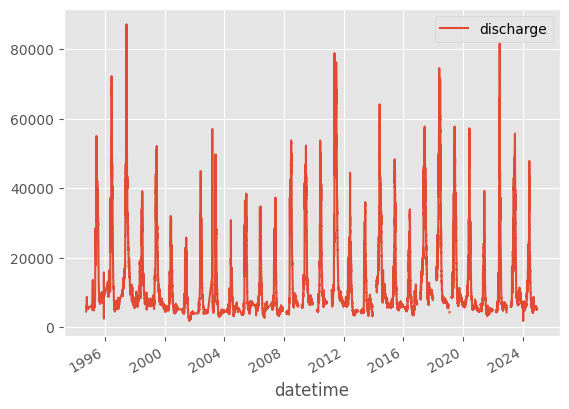

In [4]:
# Convert the discharge column to numeric, coercing errors to NaN
data['discharge'] = pd.to_numeric(data['discharge'], errors='coerce')

# Plot the data
data.plot(x='datetime', y='discharge')

In [5]:
data['year']=data['datetime'].dt.year

data.head()

,agency_cd,id,datetime,timezone,discharge,discharge_quality,gage_height,gage_height_quality,year
0,USGS,6295000,1994-10-01 01:00:00,MDT,4520.0,A:[91],NaN,NaN,1994
1,USGS,6295000,1994-10-01 02:00:00,MDT,4550.0,A:[91],NaN,NaN,1994
2,USGS,6295000,1994-10-01 03:00:00,MDT,4550.0,A:[91],NaN,NaN,1994
3,USGS,6295000,1994-10-01 04:00:00,MDT,4550.0,A:[91],NaN,NaN,1994
4,USGS,6295000,1994-10-01 05:00:00,MDT,4550.0,A:[91],NaN,NaN,1994


In [6]:
data.groupby(['year']).mean(numeric_only=True)

,id,discharge,gage_height
year,,,
1994,6295000.0,5814.791489,NaN
1995,6295000.0,15156.067002,NaN
1996,6295000.0,15998.582793,NaN
1997,6295000.0,20493.776412,NaN
1998,6295000.0,11557.353020,NaN
1999,6295000.0,12573.136541,NaN
2000,6295000.0,8438.070362,NaN
2001,6295000.0,6385.435328,NaN
2002,6295000.0,9192.893882,NaN


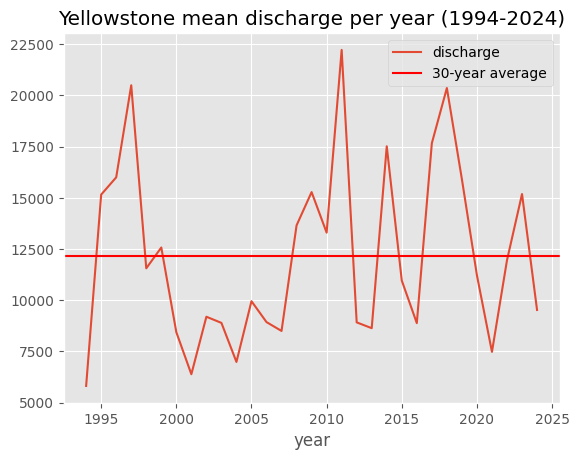

In [7]:
means = data.groupby(['year']).mean(numeric_only=True)
mean_discharge = means['discharge']
overall_mean = mean_discharge.mean()
mean_discharge.plot()
plt.axhline(y=overall_mean, color='red', label='30-year average')
plt.title("Yellowstone mean discharge per year (1994-2024)")
plt.plot(2024, mean_discharge[2024])
plt.legend()

In [8]:
data['year']

0         1994
1         1994
2         1994
3         1994
4         1994
          ... 
894518    2024
894519    2024
894520    2024
894521    2024
894522    2024
Name: year, Length: 894523, dtype: int32

In [9]:
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['day_of_year'] = data['datetime'].dt.dayofyear

In [10]:
year_2021 = data[data['year'] == 2021]
year_2022 = data[data['year'] == 2022]
year_2023 = data[data['year'] == 2023]
year_2024 = data[data['year'] == 2024]

In [11]:
year_2021

,agency_cd,id,datetime,timezone,discharge,discharge_quality,gage_height,gage_height_quality,year,month,day,day_of_year
758945,USGS,6295000,2021-01-01 00:00:00,MST,NaN,NaN,1.74,A,2021,1,1,1
758946,USGS,6295000,2021-01-01 00:15:00,MST,NaN,NaN,1.73,A,2021,1,1,1
758947,USGS,6295000,2021-01-01 00:30:00,MST,NaN,NaN,1.73,A,2021,1,1,1
758948,USGS,6295000,2021-01-01 00:45:00,MST,4330.0,A:e,1.73,A,2021,1,1,1
758949,USGS,6295000,2021-01-01 01:00:00,MST,NaN,NaN,1.74,A,2021,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
793560,USGS,6295000,2021-12-31 22:45:00,MST,NaN,NaN,1.63,A,2021,12,31,365
793561,USGS,6295000,2021-12-31 23:00:00,MST,NaN,NaN,1.64,A,2021,12,31,365
793562,USGS,6295000,2021-12-31 23:15:00,MST,NaN,NaN,1.65,A,2021,12,31,365
793563,USGS,6295000,2021-12-31 23:30:00,MST,NaN,NaN,1.66,A,2021,12,31,365


In [12]:
gage_height_2021 = year_2021[['day_of_year', 'gage_height']]
gage_height_2022 = year_2022[['day_of_year', 'gage_height']]
gage_height_2023 = year_2023[['day_of_year', 'gage_height']]
gage_height_2024 = year_2024[['day_of_year', 'gage_height']]

In [13]:
discharge_2021 = year_2021[['day_of_year', 'discharge']]
discharge_2022 = year_2022[['day_of_year', 'discharge']]
discharge_2023 = year_2023[['day_of_year', 'discharge']]
discharge_3_year = discharge_2021.merge(discharge_2022, on='day_of_year').merge(discharge_2023, on='day_of_year')
discharge_3_year.columns = ['day_of_year', 'discharge_2021', 'discharge_2022', 'discharge_2023']

Text(0.5, 0, 'Day of the year')

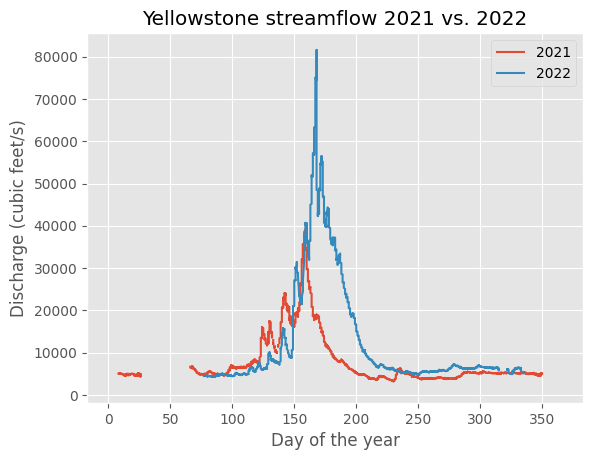

In [14]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
plt.legend()
plt.title('Yellowstone streamflow 2021 vs. 2022')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

Text(0.5, 0, 'Day of the year')

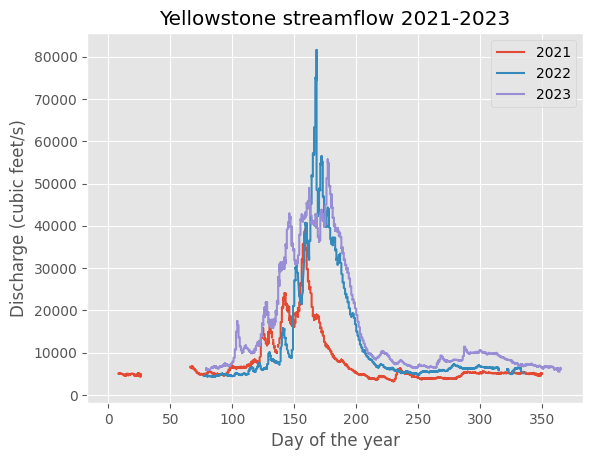

In [15]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
ax.plot(discharge_2023['day_of_year'], discharge_2023['discharge'], label='2023')
plt.legend()
plt.title('Yellowstone streamflow 2021-2023')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

In [16]:
discharge=data['discharge'].to_frame()
discharge.index=data['datetime']

Text(0.5, 0, 'Date and Time(15 min intervals)')

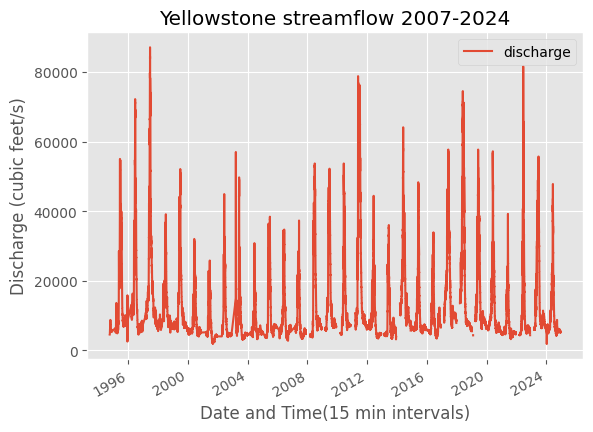

In [17]:

discharge.plot()
plt.title('Yellowstone streamflow 2007-2024')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date and Time(15 min intervals)')

In [18]:
discharge_2008 = discharge[(discharge.index >= '2008-01-01') & (discharge.index < '2009-01-01')]
discharge_2014 = discharge[(discharge.index >= '2014-01-01') & (discharge.index < '2015-01-01')]
discharge_2020 = discharge[(discharge.index >= '2020-01-01') & (discharge.index < '2021-01-01')]

Text(0.5, 0, 'Date')

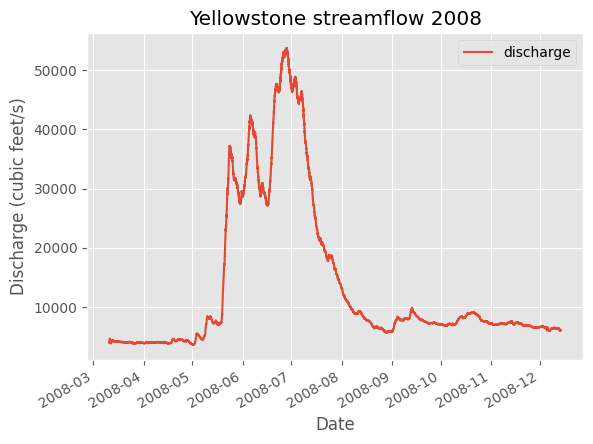

In [19]:
discharge_2008.plot()
plt.title('Yellowstone streamflow 2008')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

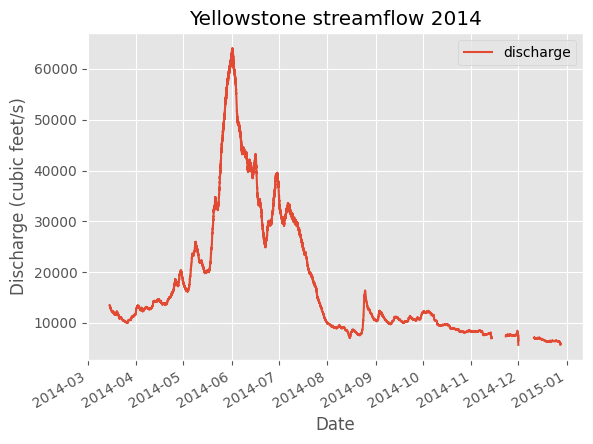

In [20]:
discharge_2014.plot()
plt.title('Yellowstone streamflow 2014')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

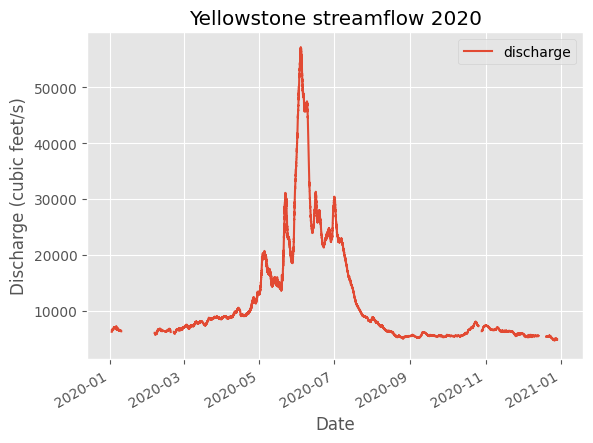

In [21]:
discharge_2020.plot()
plt.title('Yellowstone streamflow 2020')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

In [22]:
discharge['day_of_year']=discharge.index.day_of_year
discharge['week']=discharge.index.isocalendar().week.astype('int32')
discharge['month']=discharge.index.month
discharge['quarter']=discharge.index.quarter
discharge['year']=discharge.index.year

In [23]:
discharge_consolidated = discharge.copy()
discharge_consolidated = discharge_consolidated.groupby(['year', 'day_of_year']).first()

([<matplotlib.axis.XTick at 0x7f319d9236b0>,
 [Text(0, 0, '1'),
  Text(5, 0, '6'),
  Text(10, 0, '11'),
  Text(15, 0, '16'),
  Text(20, 0, '21'),
  Text(25, 0, '26'),
  Text(30, 0, '31'),
  Text(35, 0, '36'),
  Text(40, 0, '41'),
  Text(45, 0, '46'),
  Text(50, 0, '51')])

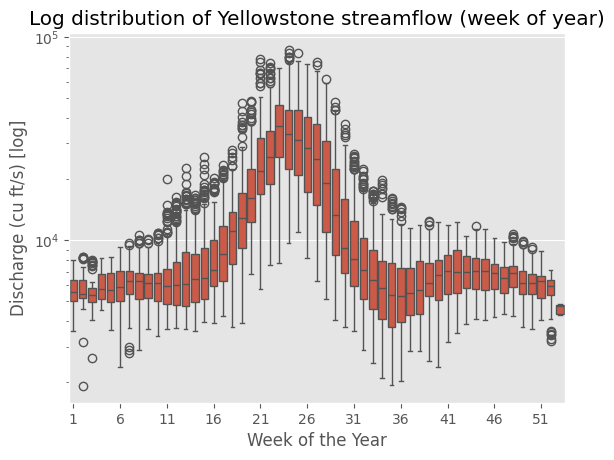

In [24]:
sns.boxplot(data=discharge_consolidated, x='week', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Week of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (week of year)')

plt.xticks(range(0, 53, 5))

Text(0.5, 1.0, 'Log distribution of Yellowstone streamflow (month of year)')

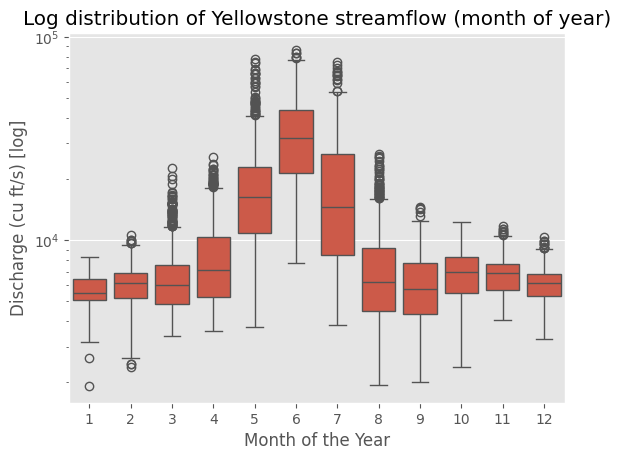

In [25]:
sns.boxplot(data=discharge_consolidated,x='month', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Month of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (month of year)')

# Prediction

In [26]:
train = discharge[discharge['year']<2023]
test = discharge[discharge['year']>=2023]

Text(0, 0.5, 'Discharge (cu ft/s)')

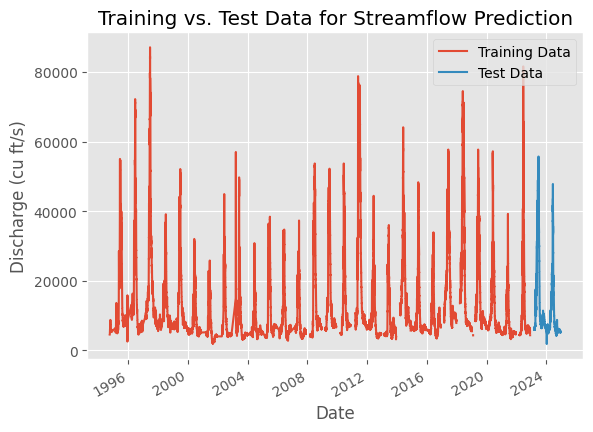

In [27]:
fig, ax = plt.subplots()
train['discharge'].plot(ax=ax)
test['discharge'].plot(ax=ax)
plt.legend(['Training Data', 'Test Data'])
plt.title('Training vs. Test Data for Streamflow Prediction')
plt.xlabel('Date')
plt.ylabel('Discharge (cu ft/s)')

In [28]:
features = ['month','week', 'day_of_year']
target = 'discharge'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [29]:
# Remove NaN values from y_train and y_test
y_train = y_train.dropna()
y_test = y_test.dropna()

# Ensure x_train and x_test match the indices of y_train and y_test
x_train = x_train.loc[y_train.index]
x_test = x_test.loc[y_test.index]

regressor = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
eval_set = [(x_train, y_train), (x_test, y_test)]
regressor.fit(x_train, y_train, eval_set=eval_set, verbose=20)

[0]	validation_0-rmse:9730.24441	validation_1-rmse:8130.39512
[20]	validation_0-rmse:7326.14761	validation_1-rmse:4515.76409
[40]	validation_0-rmse:7319.66675	validation_1-rmse:4507.41965
[60]	validation_0-rmse:7318.22190	validation_1-rmse:4507.24388
[80]	validation_0-rmse:7315.84517	validation_1-rmse:4509.10602
[100]	validation_0-rmse:7315.31778	validation_1-rmse:4510.50496
[120]	validation_0-rmse:7314.98098	validation_1-rmse:4510.52361
[134]	validation_0-rmse:7314.83788	validation_1-rmse:4510.48694


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
pd.set_option('mode.chained_assignment', None)

# Reindex x_test to match the index of test
x_test_reindexed = x_test.reindex(test.index)

# Make predictions
test['prediction'] = regressor.predict(x_test_reindexed)

Text(0.5, 1.0, 'Feature Importance')

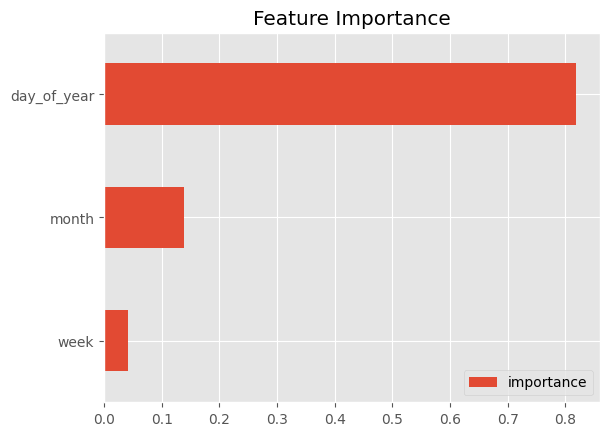

In [31]:
importance = pd.DataFrame(data=regressor.feature_importances_, index=regressor.feature_names_in_,
            columns=['importance'])
importance = importance.sort_values('importance')
importance.plot.barh()
plt.title('Feature Importance')

Text(0.5, 1.0, 'Model vs. 2023 Discharge Data')

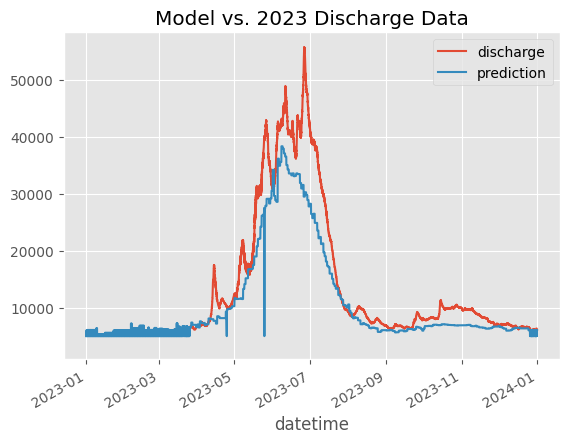

In [32]:
predicted_2023 = test[test['year'] == 2023]
predicted_2023.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2023 Discharge Data')

Text(0.5, 1.0, 'Model vs. 2024 Discharge Data')

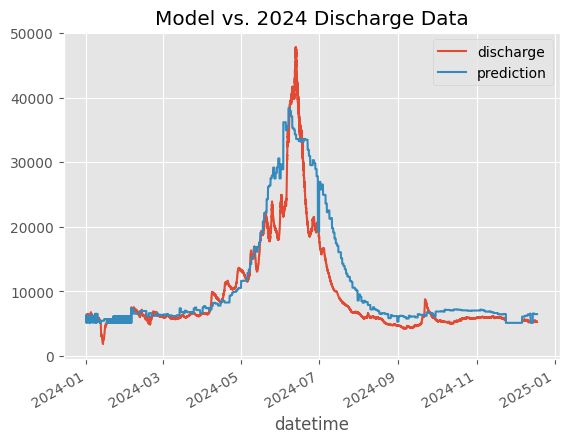

In [33]:
predicted_2024 = test[test['year'] == 2024]
predicted_2024.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2024 Discharge Data')